In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
import tensorflow_addons as tfa
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import random
import time
from pathlib import Path

from tqdm import tqdm

import re
from IPython import display

BATCH_SIZE = 64

/home/wangyuwen/.local/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
x_train = np.load('/home/Datasets/kaggle4_cifar10/x_train_cifar10_unlearn.npy')
y_train = np.load('/home/Datasets/kaggle4_cifar10/y_train_cifar10.npy')
x_val = np.load('/home/Datasets/kaggle4_cifar10/x_val_cifar10.npy')
y_val = np.load('/home/Datasets/kaggle4_cifar10/y_val_cifar10.npy')
x_test = np.load('/home/Datasets/kaggle4_cifar10/x_test_cifar10.npy')

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [4]:
def rgb2gray(img_dir):
    res = []
    for i in range(len(img_dir)):
        img = img_dir[i]*255
        img = img.astype(np.uint8)
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray_img = gray_img/255
        res.append(gray_img)
        
    return np.asarray(res)

In [5]:
def dummy_rgb(gray):
    dummy_RGB_images = np.repeat(gray[..., np.newaxis], 3, -1)
    
    return dummy_RGB_images

In [6]:
x_gray_train = rgb2gray(x_train)
x_gray_val = rgb2gray(x_val)
x_gray_test = rgb2gray(x_test)

#x_gray_train = x_gray_train.reshape(len(x_gray_train), 32, 32, 1)
#x_gray_val = x_gray_val.reshape(len(x_gray_val), 32, 32, 1)

dummy_train = dummy_rgb(x_gray_train)
dummy_val = dummy_rgb(x_gray_val)
dummy_test = dummy_rgb(x_gray_test)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((dummy_train, y_train))
train_dataset = train_dataset.shuffle(100)
batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((dummy_val, y_val))
val_dataset = val_dataset.shuffle(100)
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

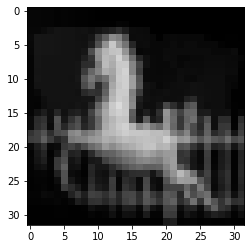

In [8]:
for data in batched_dataset.take(1):
    plt.imshow(data[0][3], cmap='gray')

In [9]:
densenet = tf.keras.applications.densenet.DenseNet201(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 3), pooling=None
)

In [10]:
model = Sequential()

In [11]:
model.add(densenet)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.7))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1, 1, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 512)               983552    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [13]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

In [14]:
checkpoint_filepath = './ckpt/checkpoint{epoch}/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath, save_weights_only = True,
    monitor = 'val_acc', mode = 'max', save_best_only = True
)

In [15]:
history = model.fit(x=batched_dataset, validation_data=batched_val_dataset, epochs=200, callbacks=[model_checkpoint_callback])

Epoch 1/200
1250/1250 [==============================] - 68s 54ms/step - loss: 2.3250 - acc: 0.1682 - val_loss: 2.9940 - val_acc: 0.1083
Epoch 2/200
1250/1250 [==============================] - 65s 52ms/step - loss: 1.8865 - acc: 0.2835 - val_loss: 2.7464 - val_acc: 0.1665
Epoch 3/200
1250/1250 [==============================] - 66s 53ms/step - loss: 1.6985 - acc: 0.3735 - val_loss: 1.8388 - val_acc: 0.3305
Epoch 4/200
1250/1250 [==============================] - 65s 52ms/step - loss: 1.5736 - acc: 0.4383 - val_loss: 3.0179 - val_acc: 0.2227
Epoch 5/200
1250/1250 [==============================] - 67s 53ms/step - loss: 1.4884 - acc: 0.4816 - val_loss: 2.0553 - val_acc: 0.3500
Epoch 6/200
1250/1250 [==============================] - 67s 54ms/step - loss: 1.3589 - acc: 0.5415 - val_loss: 1.5474 - val_acc: 0.4718
Epoch 7/200
1250/1250 [==============================] - 67s 54ms/step - loss: 1.2574 - acc: 0.5829 - val_loss: 1.3172 - val_acc: 0.5460
Epoch 8/200
1250/1250 [==================

1250/1250 [==============================] - 71s 56ms/step - loss: 0.0863 - acc: 0.9781 - val_loss: 1.6606 - val_acc: 0.6538
Epoch 61/200
1250/1250 [==============================] - 71s 57ms/step - loss: 0.0762 - acc: 0.9807 - val_loss: 1.8331 - val_acc: 0.6425
Epoch 62/200
1250/1250 [==============================] - 71s 57ms/step - loss: 0.0757 - acc: 0.9811 - val_loss: 1.6262 - val_acc: 0.6673
Epoch 63/200
1250/1250 [==============================] - 71s 57ms/step - loss: 0.0908 - acc: 0.9773 - val_loss: 1.7496 - val_acc: 0.6267
Epoch 64/200
1250/1250 [==============================] - 71s 57ms/step - loss: 0.1024 - acc: 0.9747 - val_loss: 1.6403 - val_acc: 0.6668
Epoch 65/200
1250/1250 [==============================] - 71s 56ms/step - loss: 0.0619 - acc: 0.9834 - val_loss: 1.8804 - val_acc: 0.6386
Epoch 66/200
1250/1250 [==============================] - 69s 55ms/step - loss: 0.0613 - acc: 0.9842 - val_loss: 2.2652 - val_acc: 0.5932
Epoch 67/200
1250/1250 [=======================

1250/1250 [==============================] - 65s 52ms/step - loss: 0.0361 - acc: 0.9909 - val_loss: 1.9009 - val_acc: 0.6691
Epoch 120/200
1250/1250 [==============================] - 65s 52ms/step - loss: 0.0389 - acc: 0.9903 - val_loss: 2.1466 - val_acc: 0.6355
Epoch 121/200
1250/1250 [==============================] - 65s 52ms/step - loss: 0.0465 - acc: 0.9894 - val_loss: 1.9506 - val_acc: 0.6659
Epoch 122/200
1250/1250 [==============================] - 65s 52ms/step - loss: 0.0374 - acc: 0.9914 - val_loss: 1.9102 - val_acc: 0.6433
Epoch 123/200
1250/1250 [==============================] - 65s 52ms/step - loss: 0.0405 - acc: 0.9904 - val_loss: 2.0491 - val_acc: 0.6485
Epoch 124/200
1250/1250 [==============================] - 65s 52ms/step - loss: 0.0357 - acc: 0.9916 - val_loss: 2.0339 - val_acc: 0.6321
Epoch 125/200
1250/1250 [==============================] - 65s 52ms/step - loss: 0.0425 - acc: 0.9896 - val_loss: 1.8050 - val_acc: 0.6622
Epoch 126/200
1250/1250 [================

1250/1250 [==============================] - 65s 52ms/step - loss: 0.0295 - acc: 0.9926 - val_loss: 2.0293 - val_acc: 0.6465
Epoch 179/200
1250/1250 [==============================] - 65s 52ms/step - loss: 0.0205 - acc: 0.9952 - val_loss: 1.9387 - val_acc: 0.6599
Epoch 180/200
1250/1250 [==============================] - 65s 52ms/step - loss: 0.0469 - acc: 0.9886 - val_loss: 1.8265 - val_acc: 0.6662
Epoch 181/200
1250/1250 [==============================] - 65s 52ms/step - loss: 0.0139 - acc: 0.9966 - val_loss: 2.0626 - val_acc: 0.6721
Epoch 182/200
1250/1250 [==============================] - 65s 52ms/step - loss: 0.0236 - acc: 0.9947 - val_loss: 1.9744 - val_acc: 0.6433
Epoch 183/200
1250/1250 [==============================] - 65s 52ms/step - loss: 0.0227 - acc: 0.9950 - val_loss: 2.0168 - val_acc: 0.6698
Epoch 184/200
1250/1250 [==============================] - 65s 52ms/step - loss: 0.0214 - acc: 0.9948 - val_loss: 1.9161 - val_acc: 0.6783
Epoch 185/200
1250/1250 [================

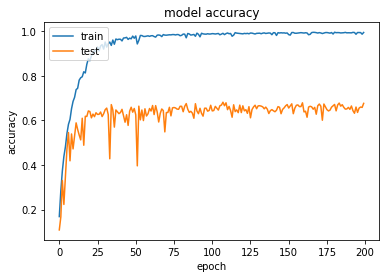

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
model.load_weights(checkpoint_filepath.format(epoch=108))

In [18]:
result = model.predict(dummy_test)

In [19]:
result = np.argmax(result, axis = 1)

In [20]:
array = []
for i in range(len(dummy_test)):
    array.append(i)

In [21]:
d = {'Id': array,'label': result}
output_test_pred = pd.DataFrame(data = d)
output_test_pred.to_csv('test_pred.csv', index = False)